# INTRODUCTION TO LOGISTIC REGRESSION

# DO WORK

Open up the lesson 9 notebook and make a copy with your name as usual

Read through the following questions and brainstorm answers for each:
- **Write down the differences between L1 and L2 regularization**
  - What do they do?
  - When should I use each?

- **What are the main differences between linear and KNN models?**
  - What is different about how they approach solving the problem? 
  - For example, what is interpretable about OLS compared to what's interpretable in KNN?

- **What would be the advantage of using a linear model like OLS to solve a classification problem, compared to KNN?**

- **What are some challenges for using OLS to solve a classification problem (say, if the values were either 1 or 0)?**

# LEARNING OBJECTIVES


- Build a Logistic regression classification model using the scikit learn library
- Describe a sigmoid function, odds, and the odds ratio as well as how they relate to logistic regression
- Evaluate a model using metrics such as classification accuracy/error, confusion matrix, ROC/AUC curves, and loss functions

# PRE-WORK REVIEW

Implement a linear model (LinearRegression) with sklearn

Understand what a coefficient is

Recall metrics such as accuracy and misclassification

Recall the differences between L1 and L2 regularization


# LOGISTIC REGRESSION



Logistic regression is a linear approach to solving a classification problem.

That is, we can use a linear model, similar to Linear regression, in order to solve if an item belongs or does not belong to a class label.

**Why might we use logistic regression over KNN for classification?**
- Logistic regression can handle dimensionality better than KNN 
- We can influence dimensionality using L1 and L2 regularization
- Most relationships can be summarized well using a line so this is a good first step

### KNOWLEDGE CHECK

1. What is classification?
2. Why is it difficult to use linear regression for classification?
3. Is there anything about the X matrix that prevents us using linear regression for a classification problem?

ANSWER:
1. A machine learning problem where we predict a class or discrete value
2.
- Regression results can have a value range from -∞ to ∞. Which neither corresponds to classes or probabilities. Regression does not know how to select a class and only works with continuous values.
3. Not really, we didn't have to change much about X to use KNN after all.

In [1]:
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import metrics
from sklearn import linear_model
from sklearn import dummy

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1)
%matplotlib inline


In [2]:
# load data
df = pd.read_csv('assets/dataset/admissions.csv')

# check first few rows of data
df.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


In [3]:
# check for missing values in each column before dropping
print "Missing values:"
print df.isnull().sum()

Missing values:
admit       0
gre         2
gpa         2
prestige    1
dtype: int64


In [4]:
# drop missing values if there are any
if df.isnull().sum().sum():
    print "There are missing values"
    df = df.dropna()
    print "Missing values dropped"

There are missing values
Missing values dropped


In [5]:
# check for missing values in each column after dropping
print "Missing values:"
print df.isnull().sum()

Missing values:
admit       0
gre         0
gpa         0
prestige    0
dtype: int64


In [6]:
# get dummy variables for prestige
df = df.join(pd.get_dummies(df['prestige'], prefix='prestige'))

In [7]:
# check for newly added columns
df.head()

,admit,gre,gpa,prestige,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,380.0,3.61,3.0,0.0,0.0,1.0,0.0
1,1,660.0,3.67,3.0,0.0,0.0,1.0,0.0
2,1,800.0,4.00,1.0,1.0,0.0,0.0,0.0
3,1,640.0,3.19,4.0,0.0,0.0,0.0,1.0
4,0,520.0,2.93,4.0,0.0,0.0,0.0,1.0


In [8]:
# for now let's only look at the lowest prestige schools since they're acceptance rates are a bit higher
df1 = df[df['prestige_1.0'] == 1].copy()

## Let’s look at some approaches to make classification with regression feasible.

### FIX 1:  PROBABILITY

One approach is to predict the probability that an observation belongs to a certain class rather than predicting the class.

That is, we can predict that a student has a 54% chance of being admitted.

**Is there any kind of base rate?**

When working with regression the simplest meaningful prediction was the mean. Our models our only useful if they do better than the mean.

For classification we can look at the **prior probability** of a class.

For example, roughly 700 of 2200 people from the Titanic survived.  Without knowing anything about the passengers or crew, the probability of survival would be ~0.32 (32%).

We can then use a linear function to either increase or decrease the probability of an observation given the data about it.

## KNOWLEDGE CHECK

Recall the linear regression formula.

$$y = \alpha + \beta X + \epsilon$$

1. The prior probability is most similar to which value in the ordinary least squares formula? (It's inuitively close, but mathematically not the same unless your data is normalized.)

2. What if 97% of our data is one class. What is the accuracy if we just predict the most common class?

<!--
1. We are looking for the value that represents the average survival probability when excluding all other factors. That would be, alpha, the intercept.(You can think of a model that does not account for any other factors as one whose all Beta coefficients are zero)

2. The accuracy would be 97%. That looks good on paper, but it's not very useful since we aren't getting insight. This is the well known problem of class imbalance. There are some solutions that involve using the appropriate evaluation metric, the appropriate algorithm, the appropriate experimental design, or the appropriate evaluation procedure. We can spend several classes talking about this, so we'll only go into one solution.
-->

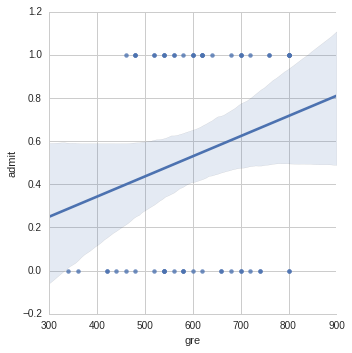

In [9]:
# Plot a linear regression of admit on gre
sns.lmplot('gre', 'admit', df1)

Admit rate:  0.540983606557
Average GRE:  611.803278689


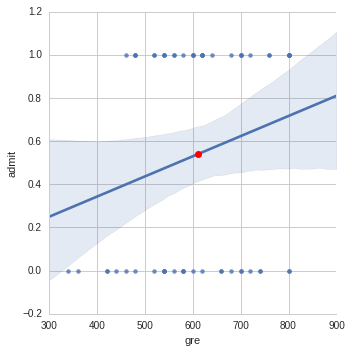

In [10]:
# Remember that linear regression with an intercept will ALWAYS go through the mean of Y and X
# Plot a linear regression of admit on gre and label the average point
print 'Admit rate: ', df1.admit.mean()
print 'Average GRE: ', df1.gre.mean()
sns.lmplot('gre', 'admit', df1)
plt.plot(df1.gre.mean(), df1.admit.mean(), 'ro')

In [11]:
# Fit the linear model shown above
X = df1[['gre']]
y = df1['admit']
lm = linear_model.LinearRegression().fit(X, y)
lm_pred = lm.predict(X)

In [12]:
# Remember, we read this as a unit increase in GRE score leads to a unit increase in the probability of getting admitted
lm.coef_

array([ 0.00093428])

In [17]:
lm.intercept_ + lm.coef_[0]*400

0.34309946029298394

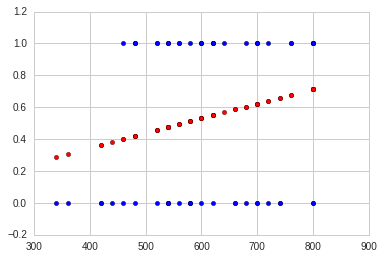

In [13]:
# Plot the model predictions
plt.figure()
plt.scatter(X, y)
plt.scatter(X, lm_pred, c='red')

### KNOWLEDGE CHECK

What would be the problem with our predictions if the line of best fit had a very steep slope?
<!--
ANSWER:
Our predictions might be greater than 1 or less than 0. In other words, they could fall outside the acceptable range for probabilities.
-->

### FIX 2: SIGMOID FUNCTIONS AND LINK FUNCTIONS

### SIGMOID FUNCTIONS

A sigmoid function is a mathematical function that visually looks like an s.

This allows us to take a infinite set of possible values and squeeze them into a range between 0 and 1.

For classification, we need a distribution associated with categories:  given all events, what is the probability of a given event?

Probabilities range from 0 to 1

The sigmoid function that best allows for this is the logit function since its output ranges from 0 to 1; Others that are commonly used in machine learning are the cumulative normal distribution, the arc tangent, and hyperbolic tangent.

### LINK FUNCTIONS

Linear models can be extended to generalized linear models using a link function.

**What is a link function? (Sometimes refered to as a kernel)**

Link functions allows us to build a relationship between a linear function and the mean of a distribution.

This lets us create non-linear relationships

For count data $(0, \infty)$ we might use the exponential function
$$y = e^{\alpha + \beta X}$$

This takes values from ($-\infty$, $\infty$) and outputs values from $(0, \infty)$



For binary data we will use the logistic function

$$y = \frac{1}{1 + e^{-(\alpha + \beta X)}}$$

This takes values from ($-\infty$, $\infty$) and outputs values from $(0, 1)$

**It's not very clear in this dataset, but the logistic fit looks something like this in the extreme case**
![log_vs_ols](assets/images/log_vs_ols.jpg)

In [22]:
logit.predict_proba(X)[:, 1]

array([ 0.62692334,  0.53337999,  0.48526878,  0.61178464,  0.58867479,
        0.52538034,  0.62692334,  0.55726   ,  0.51736766,  0.45329098,
        0.5413625 ,  0.55726   ,  0.5413625 ,  0.62692334,  0.52538034,
        0.55726   ,  0.58867479,  0.59642709,  0.58867479,  0.54932384,
        0.62692334,  0.54932384,  0.54932384,  0.50131958,  0.60413154,
        0.62692334,  0.50131958,  0.58867479,  0.58867479,  0.54932384,
        0.60413154,  0.56516703,  0.44534611,  0.49329245,  0.49329245,
        0.50131958,  0.62692334,  0.51736766,  0.52538034,  0.57304105,
        0.5413625 ,  0.62692334,  0.62692334,  0.50131958,  0.53337999,
        0.52538034,  0.52538034,  0.58087822,  0.4772527 ,  0.55726   ,
        0.52538034,  0.61178464,  0.59642709,  0.51736766,  0.52538034,
        0.53337999,  0.5413625 ,  0.58087822,  0.55726   ,  0.57304105,
        0.4772527 ])

In [42]:
# Fit a logistic regression on the same data as before
X = df1[['gre']]
y = df1['admit']
logit = linear_model.LogisticRegression(C=1e9).fit(X, y)
logit_pred = logit.predict_proba(X)[:, 1]
# predict_proba return the probability of every class
# In this case we have two classes and we retrieve probabilities of positive class

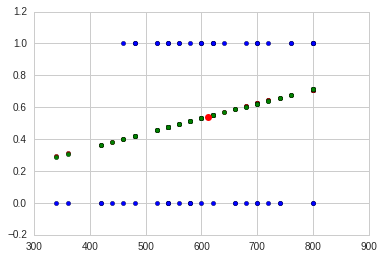

In [43]:
# Plot both the linear model and logistic model
plt.figure()
plt.scatter(X, y)
plt.scatter(X, logit_pred, c='red')
plt.scatter(X, lm_pred, c='green')
plt.plot(df1.gre.mean(), df1.admit.mean(), 'ro')

It's hard to see, but the red line is very slightly curved.

## ACTIVITY:  KNOWLEDGE CHECK

What is the probably of a student getting accepted with a GRE score of 800?

<!--
Roughly 60-70%.
-->

### FIX 3: PROBABILITY, ODDS, e, LOG, LOG-ODDS

$$probability= \frac{one~outcome}{all~outcomes}$$

$$odds= \frac{one~outcome}{all~other~outcomes}$$

Examples:

    Dice roll of 1: probability = 1/6, odds = 1/5
    Even dice roll: probability = 3/6, odds = 3/3 = 1
    Dice roll less than 5: probability = 4/6, odds = 4/2 = 2

$$odds=\frac{probability}{1−probability}$$

$$probability= \frac{odds}{1+odds}$$

Does that look familiar?

**Deriving the logistic function**

A convenient transformation is to take the log of odds to make the values symmetric
$$\log{(\frac{p}{1-p})}$$

Remember how we want y in our regression to represent the probability of a certain class?

$$\log{(\frac{y}{1-y})} = \alpha + \beta X$$

$$\frac{y}{1-y} = e^{\alpha + \beta X}$$

$$\frac{1}{\frac{1}{y}-1} = e^{\alpha + \beta X}$$

$$\frac{1}{y} = 1 + e^{-(\alpha + \beta X)}$$


Once you do the algebra, this is the same as
$$y = \frac{1}{1 + e^{-(\alpha + \beta X)}}$$

In [25]:
# create a table of probability versus odds
odds_table = pd.DataFrame({'probability':[0.1, 0.2, 0.25, 0.5, 0.6, 0.8, 0.9]})
odds_table['odds'] = odds_table.probability/(1 - odds_table.probability)
odds_table['log_odds'] = np.log(odds_table['odds'])
odds_table

,probability,odds,log_odds
0,0.10,0.111111,-2.197225
1,0.20,0.250000,-1.386294
2,0.25,0.333333,-1.098612
3,0.50,1.000000,0.000000
4,0.60,1.500000,0.405465
5,0.80,4.000000,1.386294
6,0.90,9.000000,2.197225


In [44]:
logit.intercept_ + logit.coef_[0]*700 - (logit.intercept_ + logit.coef_[0]*701)

array([-0.00381703])

In [26]:
logit.coef_

array([[ 0.00160551]])

### KNOWLEDGE CHECK

Pretend the coefficient on gre is 0.00160551. How do we interpret this?

<!--
ANSWER:
This means that the log-odds of admittance go up by 0.00160551 for a unit increase in GRE
-->

# INDEPENDENT PRACTICE

LOGISTIC REGRESSION IMPLEMENTATION


## ACTIVITY: LOGISTIC REGRESSION IMPLEMENTATION
DIRECTIONS (15 minutes)

Use the data collegeadmissions.csv and the LogisticRegression estimator in sklearn to predict the target variable admit.  

1. What is the bias, or prior probability, of the dataset?
2. Build a simple model with one feature and explore the coef_ value.  Does this represent the odds or logit (log odds)?
3. Build a more complicated model using multiple features.  Interpreting the odds, which features have the most impact on admission rate?  Which features have the least?
4. What is the accuracy of your model?

In [31]:
import pandas as pd
from sklearn import linear_model, cross_validation, metrics

admissions = pd.read_csv('assets/dataset/admissions.csv')
admissions = admissions.dropna()
# get dummy variables for prestige
admissions = admissions.join(pd.get_dummies(admissions['prestige'], prefix='prestige'))

In [ ]:
# 1. What is the prior probability of the dataset?
admissions.admit.mean()

In [36]:
# 2. Build a simple model with one feature and explore the coef_ value.  Does this represent the odds or logit (log odds)?
X = admissions[['gre']]
y = admissions['admit']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, random_state=42)

In [37]:
logit_simple = linear_model.LogisticRegression().fit(X_train, y_train)

In [38]:
logit_simple.coef_

array([[ 0.00243004]])

In [57]:
# 3. Build a more complicated model using multiple features.  Interpreting the odds, which features have the most impact on admission rate?  Which features have the least?
X = admissions[['gre', 'prestige_1.0', 'prestige_2.0', 'prestige_3.0']]
y = admissions['admit']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, random_state=42)

In [58]:
logit = linear_model.LogisticRegression(C=100000000).fit(X_train, y_train)

In [59]:
logit.coef_

array([[ 0.0038229 ,  1.50139544,  1.07119057,  0.24536784]])

In [60]:
# 4. What is the accuracy of your model?
print metrics.accuracy_score(y_train, logit.predict(X_train))
print metrics.accuracy_score(y_test, logit.predict(X_test))

0.723905723906
0.63


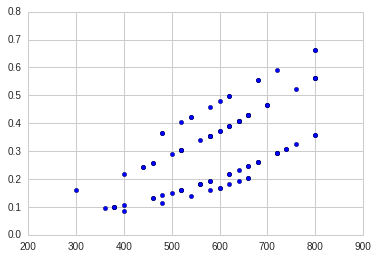

In [63]:
plt.figure()
plt.scatter(X_test[['gre']], logit.predict_proba(X_test)[:,1])

# BREAK

# ADVANCED CLASSIFICATION METRICS

Accuracy is only one of several metrics used when solving a classification problem.

$$Accuracy = \frac{total~predicted~correct}{total~predicted}$$

Accuracy alone doesn’t always give us a full picture.

If we know a model is 75% accurate, it doesn’t provide any insight into why the 25% was wrong.

Consider a binary classification problem where we have 165 observations/rows of people who are either smokers or non-smokers. 

<table width=150px style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
</tr>

</table>

There are 60 in class 0, non-smokers, and 105 observations in class 1, smokers
<table width=150px style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
</tr>

</table>

We have 55 predictions of class, predicted as non-smoker and 110 of class 1, predicted to be a smoker

<table width=150px style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">55</td>
    <td style="text-align: center">110</td>
</tr>

</table>

- **true positives (TP):** These are cases in which we predicted yes (smokers), and they actually are smokers.
- **true negatives (TN):** We predicted no, and they are non-smokers.
- **false positives (FP):** We predicted yes, but they were not actually smokers. (Also known as a "Type I error.")
- **false negatives (FN):** We predicted no, but they are smokers. (Also known as a "Type II error.")
<table width=150px style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center">TN = 50</td>
    <td style="text-align: center">FP = 10</td>
    <td style="text-align: center">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center">FN = 5</td>
    <td style="text-align: center">TP = 100</td>
    <td style="text-align: center">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">55</td>
    <td style="text-align: center">110</td>
</tr>

</table>

### KNOWLEDGE CHECK

Try not to look at the answers above.

Categorize these as TP, TN, FP, FN:
    
- We predict non-smoker, but the person is a smoker
- We predict non-smoker, and the person is a non-smoker
- We predict smoker and the person is a smoker
- We predict smoker and the persin is a non-smoker

ANSWER
- FN
- TN
- TP
- FP

### SIMPLE METRICS

**Accuracy:** Overall, how often is the classifier correct?

<span>
    (<span style="color: green">TP</span>+<span style="color: red">TN</span>)/<span style="color: blue">total</span> = (<span style="color: green">100</span>+<span style="color: red">50</span>)/<span style="color: blue">165</span> = 0.91
</span>

<table width=150px style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom; color: blue">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center; background-color: red">TN = 50</td>
    <td style="text-align: center">FP = 10</td>
    <td style="text-align: center">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center">FN = 5</td>
    <td style="text-align: center; background-color: green">TP = 100</td>
    <td style="text-align: center">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">55</td>
    <td style="text-align: center">110</td>
</tr>

</table>

**True Positive Rate (TPR)** asks, “Out of all of the target class labels, how many were accurately predicted to belong to that class?”

For example, given a medical exam that tests for cancer, how often does it correctly identify patients with cancer?

<span>
<span style="color: green">TP</span>/<span style="color: blue">actual yes</span> = <span style="color: green">100</span>/<span style="color: blue">105</span> = 0.95
</span>

<table width=150px style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center">TN = 50</td>
    <td style="text-align: center">FP = 10</td>
    <td style="text-align: center">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center">FN = 5</td>
    <td style="text-align: center;background-color: green">TP = 100</td>
    <td style="text-align: center;color: blue">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">55</td>
    <td style="text-align: center">110</td>
</tr>

</table>

**False Positive Rate (FPR)** asks, “Out of all items not belonging to a class label, how many were predicted as belonging to that target class label?”

For example, given a medical exam that tests for cancer, how often does it trigger a “false alarm” by incorrectly saying a patient has cancer?

<span>
<span style="color: orange">FP</span>/<span style="color: blue">actual no</span> = <span style="color: orange">10</span>/<span style="color: blue">60</span> = 0.17
</span>

<table width=150px style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center">TN = 50</td>
    <td style="text-align: center;background-color: orange">FP = 10</td>
    <td style="text-align: center;color:blue">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center">FN = 5</td>
    <td style="text-align: center">TP = 100</td>
    <td style="text-align: center">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">55</td>
    <td style="text-align: center">110</td>
</tr>

</table>

### KNOWLEDGE CHECK

Can you see that we might weigh TPR AND FPR differently depending on the sitution?

- Give an example when we care about TPR, but not FPR
- Give an example when we care about FPR, but not TPR

ANSWER:
- During initial medical diagnosis, we want to be sensitive. We want intial screens to come up a lot of True Positives even if we get a lot of False Positives.
- If we are doing spam detection we want to be precise. Anything that we remove from an inbox must be spam, which may mean accepting fewer True Positives.

**More trade-offs**

The true positive and false positive rates gives us a much clearer pictures of where predictions begin to fall apart.

This allows us to adjust our models accordingly.

In [64]:
import pandas as pd
from sklearn import linear_model, cross_validation, metrics

admissions = pd.read_csv('assets/dataset/admissions.csv')
admissions = admissions.dropna()
# get dummy variables for prestige
admissions = admissions.join(pd.get_dummies(admissions['prestige'], prefix='prestige'))

In [71]:
X = admissions[['gre']]
y = admissions['admit']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, random_state=46)
logit_simple = linear_model.LogisticRegression(C=1e9).fit(X_train, y_train)

In [72]:
y_train.mean()

0.30303030303030304

In [73]:
# Get probability predictions
logit_pred_proba = logit_simple.predict_proba(X_test)[:,1]

In [74]:
metrics.confusion_matrix(y_true=y_test, y_pred=logit_pred_proba > .5)

array([[64,  0],
       [36,  0]])

### KNOWLEDGE CHECK
- What is our accuracy on the test set?
- True Positive Rate?
- False Positive Rate?

ANSWER: This will depend on the data:
Accuracy: 64%
TPR: 0
FPR: 0

A good classifier would have a true positive rate approaching 1 and a false positive rate approaching 0.

In our smoking problem, this model would accurately predict all of the smokers as smokers and not accidentally predict any of the nonsmokers as smokers.

We can vary the classification threshold for our model to get different predictions.  

In [75]:
metrics.confusion_matrix(y_true=y_test, y_pred=logit_pred_proba > .3)

array([[37, 27],
       [10, 26]])

## ROC

**But how do we know if a model is better overall than other model?**

It can often be difficult to optimize two numbers at once.

Logically, we like a single number for optimization.

Can you think of any ways to combine our two metrics?

This is where the **Receiver Operation Characteristic (ROC) curve** comes in handy.

The curve is created by plotting the **true positive rate** against the **false positive rate** at various model threshold settings.

**Area Under the Curve (AUC)** summarizes the impact of **TPR** and **FPR** in one single value.

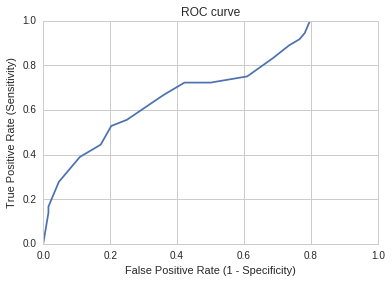

In [76]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, logit_pred_proba)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

**What does it actually mean?**
- Consider the ideal classifier. 
- It only makes True Positives and True Negatives. 
- Naturally True Positives are associated with probabilities of near 1 while True Negatives are associated with probabilities of near 0.

**What happens when we adjust a threshold for prediction?**
- A threshold of 1 gives us no True Positives, hence a TPR of 0
- A lower threshold either produces a True Positive or a False Positive
- Eventually we run out of positives and being producing True Negatives and False Negatives
- In the chart, starting from (0, 0), this means that each threshold change either moves the line up for a TP or the line right for a FP.
- http://stats.stackexchange.com/questions/105501/understanding-roc-curve

**What is the best ROC curve?**
- We want a curve that sticks to the upper left hand corner
- This means all True Positives come first and True Negatives come later
- ROC actually measures if we ranked probabilities in the correct order


With this curve, we can find the **Area Under the Curve (AUC)** which summarizes the relationship in the ROC as a single number

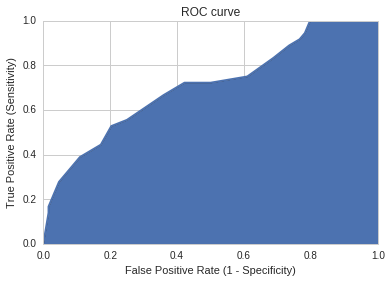

In [77]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, logit_simple.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

If we have a TPR of 1 (all positives are marked positive) and FPR of 0 (all negatives are not marked positive), we’d have an AUC of 1.  This means everything was accurately predicted.

If we have a TPR of 0 (all positives are not marked positive) and an FPR of 1 (all negatives are marked positive), we’d have an AUC of 0.  This means nothing was predicted accurately.

An AUC of 0.5 would suggest randomness (somewhat) and is an excellent benchmark to use for comparing predictions (i.e. is my AUC above 0.5?).

**When should I use AUC?**
- Ranking problems -- When you need a most likely to be true prediction rather than a full set of predictions. Or when only the relative order of your predictions matters (optimization)
- AUC is robust to class imbalance since it considers all thresholds

There are several other common metrics when dealing with classification
- [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
 - Total correct
- [Sensitivty/Recall/True Positive Rate](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
- The recall is intuitively the ability of the classifier to find all the positive samples.

- [Area Under the Curve (AUC)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
 - http://stats.stackexchange.com/questions/105501/understanding-roc-curve
 - http://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it

Sklearn has all of the metrics located on one convenient page.
http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

# BREAK

### EXERCISE: WHICH METRIC SHOULD I USE?

While AUC seems like a “golden standard”, it could be further improved depending upon your problem.  There will be instances where error in positive or negative matches will be very important.

For each of the following examples: 

1. Write a confusion matrix: true positive, false positive, true negative, false negative. Then decide what each square represents for that specific example.
2. Choose a classification metric that seems appropriate for the problem


- A test is developed for determining if a patient has cancer or not.
- A newspaper company is targeting a marketing campaign for "at risk" users that may stop paying for the product soon.
- You build a spam classifier for your email system.
- Customer e-mails are classified as complaint or compliment. You want an algorithm to help you identify complaints so you can address them first

ANSWER:
- Maximize True Positive Rate even at the cost of False Positive.
- This could go either way depending on the company's strategy. In general it's easier to retain customers than get new ones, so you may want to maximize the True Positive Rate.
- Maximize Recall/ Minimize False Positive Rate people don't want their mail accidently classified as spam.
- This can be subtle, presumably you don't have enough resources to address all e-mails, so you need to make sure that the ones you look at first are in fact complaints. AUC would be appropriate.


# PRACTICE

EVALUATING LOGISTIC REGRESSION WITH ALTERNATIVE METRICS


### ACTIVITY: EVALUATING LOGISTIC REGRESSION
DIRECTIONS (35 minutes)
EXERCISE

Kaggle’s common online exercise is exploring survival data from the Titanic.
https://www.kaggle.com/c/titanic
    
Spend a few minutes determining which data would be most important to use in the prediction problem. You may need to create new features based on the data available.
Build a tuned Logistic model. Use the unit project 3 starter code as a template.

# TOPIC REVIEW

What’s the link function used in logistic regression?

What kind of machine learning problems does logistic regression address?

What do the coefficients in a logistic regression represent? How does the interpretation differ from ordinary least squares? How is it similar?


How does True Positive Rate and False Positive Rate help explain accuracy?

What would an AUC of 0.5 represent for a model? What about an AUC of 0.9?

Why might one classification metric be more important to tune than another? Give an example of a business problem or project where this would be the case.


# BEFORE NEXT CLASS
- Start working on Unit project 4 DUE Monday (this is a long one)
  - https://github.com/ga-students/DS-DC-14/tree/master/projects/unit-projects/project-4

# ADDITIONAL RESOURCES
- http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
- http://www.dataschool.io/roc-curves-and-auc-explained/

A good example of making trade-offs in practical situations
- http://blog.insightdatalabs.com/visualizing-classifier-thresholds/

Cross-Validated:
- http://stackoverflow.com/questions/tagged/logistic-regression
- FAQ's on cross-validated for AUC and Confusion Matrix don't look great


# LESSON: INTRO TO LOGISTIC REGRESSION
EXIT TICKET 

DON’T FORGET TO FILL OUT YOUR EXIT TICKET

http://goo.gl/forms/gG5qAw9QljgkHC2q1

# ADVANCED CLASSIFICATION METRICS

Accuracy is only one of several metrics used when solving a classification problem.

$$Accuracy = \frac{total~predicted~correct}{total~predicted}$$

Accuracy alone doesn’t always give us a full picture.

If we know a model is 75% accurate, it doesn’t provide any insight into why the 25% was wrong.

Consider a binary classification problem where we have 165 observations/rows of people who are either smokers or non-smokers. 

<table width=150px style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
</tr>

</table>

There are 60 in class 0, non-smokers, and 105 observations in class 1, smokers
<table width=150px style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
</tr>

</table>

We have 55 predictions of class, predicted as non-smoker and 110 of class 1, predicted to be a smoker

<table width=150px style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center"></td>
    <td style="text-align: center"></td>
    <td style="text-align: center">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">55</td>
    <td style="text-align: center">110</td>
</tr>

</table>

- **true positives (TP):** These are cases in which we predicted yes (smokers), and they actually are smokers.
- **true negatives (TN):** We predicted no, and they are non-smokers.
- **false positives (FP):** We predicted yes, but they were not actually smokers. (Also known as a "Type I error.")
- **false negatives (FN):** We predicted no, but they are smokers. (Also known as a "Type II error.")
<table width=150px style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center">TN = 50</td>
    <td style="text-align: center">FP = 10</td>
    <td style="text-align: center">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center">FN = 5</td>
    <td style="text-align: center">TP = 100</td>
    <td style="text-align: center">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">55</td>
    <td style="text-align: center">110</td>
</tr>

</table>

### KNOWLEDGE CHECK

Try not to look at the answers above.

Categorize these as TP, TN, FP, FN:
    
- We predict non-smoker, but the person is a smoker
- We predict non-smoker, and the person is a non-smoker
- We predict smoker and the person is a smoker
- We predict smoker and the persin is a non-smoker

ANSWER
- FN
- TN
- TP
- FP

### SIMPLE METRICS

**Accuracy:** Overall, how often is the classifier correct?

<span>
    (<span style="color: green">TP</span>+<span style="color: red">TN</span>)/<span style="color: blue">total</span> = (<span style="color: green">100</span>+<span style="color: red">50</span>)/<span style="color: blue">165</span> = 0.91
</span>

<table width=150px style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom; color: blue">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center; background-color: red">TN = 50</td>
    <td style="text-align: center">FP = 10</td>
    <td style="text-align: center">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center">FN = 5</td>
    <td style="text-align: center; background-color: green">TP = 100</td>
    <td style="text-align: center">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">55</td>
    <td style="text-align: center">110</td>
</tr>

</table>

**True Positive Rate (TPR)** asks, “Out of all of the target class labels, how many were accurately predicted to belong to that class?”

For example, given a medical exam that tests for cancer, how often does it correctly identify patients with cancer?

<span>
<span style="color: green">TP</span>/<span style="color: blue">actual yes</span> = <span style="color: green">100</span>/<span style="color: blue">105</span> = 0.95
</span>

<table width=150px style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center">TN = 50</td>
    <td style="text-align: center">FP = 10</td>
    <td style="text-align: center">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center">FN = 5</td>
    <td style="text-align: center;background-color: green">TP = 100</td>
    <td style="text-align: center;color: blue">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">55</td>
    <td style="text-align: center">110</td>
</tr>

</table>

**False Positive Rate (FPR)** asks, “Out of all items not belonging to a class label, how many were predicted as belonging to that target class label?”

For example, given a medical exam that tests for cancer, how often does it trigger a “false alarm” by incorrectly saying a patient has cancer?

<span>
<span style="color: orange">FP</span>/<span style="color: blue">actual no</span> = <span style="color: orange">10</span>/<span style="color: blue">60</span> = 0.17
</span>

<table width=150px style="border: none">
<tr style="border: none">
    <td style="border: none; vertical-align: bottom">n = 165</td>
    <td style=""><b>Predicted: No</b></td>
    <td style=""><b>Predicted: Yes</b></td>
</tr>
<tr>
    <td><b>Actual: No</b></td>
    <td style="text-align: center">TN = 50</td>
    <td style="text-align: center;background-color: orange">FP = 10</td>
    <td style="text-align: center;color:blue">60</td>
</tr>
<tr>
    <td><b>Actual: Yes</b></td>
    <td style="text-align: center">FN = 5</td>
    <td style="text-align: center">TP = 100</td>
    <td style="text-align: center">105</td>
</tr>
<tr style="border: none">
    <td style="border: none"></td>
    <td style="text-align: center">55</td>
    <td style="text-align: center">110</td>
</tr>

</table>

### KNOWLEDGE CHECK

Can you see that we might weigh TPR AND FPR differently depending on the sitution?

- Give an example when we care about TPR, but not FPR
- Give an example when we care about FPR, but not TPR

ANSWER:
- During initial medical diagnosis, we want to be sensitive. We want intial screens to come up a lot of True Positives even if we get a lot of False Positives.
- If we are doing spam detection we want to be precise. Anything that we remove from an inbox must be spam, which may mean accepting fewer True Positives.

**More trade-offs**

The true positive and false positive rates gives us a much clearer pictures of where predictions begin to fall apart.

This allows us to adjust our models accordingly.

In [64]:
import pandas as pd
from sklearn import linear_model, cross_validation, metrics

admissions = pd.read_csv('assets/dataset/admissions.csv')
admissions = admissions.dropna()
# get dummy variables for prestige
admissions = admissions.join(pd.get_dummies(admissions['prestige'], prefix='prestige'))

In [71]:
X = admissions[['gre']]
y = admissions['admit']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, random_state=46)
logit_simple = linear_model.LogisticRegression(C=1e9).fit(X_train, y_train)

In [72]:
y_train.mean()

0.30303030303030304

In [73]:
# Get probability predictions
logit_pred_proba = logit_simple.predict_proba(X_test)[:,1]

In [74]:
metrics.confusion_matrix(y_true=y_test, y_pred=logit_pred_proba > .5)

array([[64,  0],
       [36,  0]])

### KNOWLEDGE CHECK
- What is our accuracy on the test set?
- True Positive Rate?
- False Positive Rate?

ANSWER: This will depend on the data:
Accuracy: 64%
TPR: 0
FPR: 0

A good classifier would have a true positive rate approaching 1 and a false positive rate approaching 0.

In our smoking problem, this model would accurately predict all of the smokers as smokers and not accidentally predict any of the nonsmokers as smokers.

We can vary the classification threshold for our model to get different predictions.  

In [75]:
metrics.confusion_matrix(y_true=y_test, y_pred=logit_pred_proba > .3)

array([[37, 27],
       [10, 26]])